## Weka German Credit Dataset

Download this dataset:
https://www.kaggle.com/btolar1/weka-german-credit

The dataset contains 1000 entries with 20 categorial/symbolic attributes. In this dataset,each entry represents a person who takes a credit by a bank. Each person is classified as good or bad (CLASS attribute) credit risk according to the set of attributes.

## Task/Problem Statement
Using whichever methods and libraries you prefer, create a notebook with the following:
- Data preparation and Data exploration
- Identify the three most significant data features which drive the credit risk
- Modeling the credit risk
- Model validation and evaluation using the methods that you find correct for the problem

### Import the necessary packages

In [125]:
import warnings

warnings.filterwarnings("ignore")
# Libraries to help with reading and manipulating data
import pandas as pd
import numpy as np

# libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries to tune model, get different metric scores, and split data
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.pipeline import Pipeline, make_pipeline

#libraries to help with model building
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier)
from xgboost import XGBClassifier

# to suppress scientifiv notations
pd.set_option('display.float_format', lambda x: '%.3f' % x)

### Read & and Explore the dataset

In [126]:
data = pd.read_csv("/content/credit-g.csv")

In [127]:
data.shape  # 1000 records with 21 features

(1000, 21)

In [128]:
data.head() # Checking the first 5 rows in dataset

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6,critical/other existing credit,radio/tv,1169,no known savings,>=7,4,male single,none,4,real estate,67,none,own,2,skilled,1,yes,yes,good
1,0<=X<200,48,existing paid,radio/tv,5951,<100,1<=X<4,2,female div/dep/mar,none,2,real estate,22,none,own,1,skilled,1,none,yes,bad
2,no checking,12,critical/other existing credit,education,2096,<100,4<=X<7,2,male single,none,3,real estate,49,none,own,1,unskilled resident,2,none,yes,good
3,<0,42,existing paid,furniture/equipment,7882,<100,4<=X<7,2,male single,guarantor,4,life insurance,45,none,for free,1,skilled,2,none,yes,good
4,<0,24,delayed previously,new car,4870,<100,1<=X<4,3,male single,none,4,no known property,53,none,for free,2,skilled,2,none,yes,bad


In [129]:
data.info() # Checking the datatypes of columns in the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   checking_status         1000 non-null   object
 1   duration                1000 non-null   int64 
 2   credit_history          1000 non-null   object
 3   purpose                 1000 non-null   object
 4   credit_amount           1000 non-null   int64 
 5   savings_status          1000 non-null   object
 6   employment              1000 non-null   object
 7   installment_commitment  1000 non-null   int64 
 8   personal_status         1000 non-null   object
 9   other_parties           1000 non-null   object
 10  residence_since         1000 non-null   int64 
 11  property_magnitude      1000 non-null   object
 12  age                     1000 non-null   int64 
 13   other_payment_plans    1000 non-null   object
 14  housing                 1000 non-null   object
 15  exist


* 11 columns are of object type rest all are numerical.

In [130]:
data.describe().T # Summary of Dataset for numerical columns

,count,mean,std,min,25%,50%,75%,max
duration,1000.000,20.903,12.059,4.000,12.000,18.000,24.000,72.000
credit_amount,1000.000,3271.258,2822.737,250.000,1365.500,2319.500,3972.250,18424.000
installment_commitment,1000.000,2.973,1.119,1.000,2.000,3.000,4.000,4.000
residence_since,1000.000,2.845,1.104,1.000,2.000,3.000,4.000,4.000
age,1000.000,35.546,11.375,19.000,27.000,33.000,42.000,75.000
existing_credits,1000.000,1.407,0.578,1.000,1.000,1.000,2.000,4.000
num_dependents,1000.000,1.155,0.362,1.000,1.000,1.000,1.000,2.000


* credit_amount: There's a huge difference between the third quartile and maximum value. The range of credit limit is very wide from 3972 to 18424, customers with high credit limit might be outliers.

* Minimum number of dependents is atleast 1

In [131]:
data.nunique() # Unique values in each column

checking_status             4
duration                   33
credit_history              5
purpose                    10
credit_amount             921
savings_status              5
employment                  5
installment_commitment      4
personal_status             4
other_parties               3
residence_since             4
property_magnitude          4
age                        53
 other_payment_plans        3
housing                     3
existing_credits            4
job                         4
num_dependents              2
own_telephone               2
 foreign_worker             2
class                       2
dtype: int64

In [132]:
# number of missing values in each column
data.isnull().sum()

checking_status           0
duration                  0
credit_history            0
purpose                   0
credit_amount             0
savings_status            0
employment                0
installment_commitment    0
personal_status           0
other_parties             0
residence_since           0
property_magnitude        0
age                       0
 other_payment_plans      0
housing                   0
existing_credits          0
job                       0
num_dependents            0
own_telephone             0
 foreign_worker           0
class                     0
dtype: int64

* There are no null values in the data.

In [133]:
# Checking the individual categorical columns with value counts

for i in data.describe(include=['object']).columns:
    print('Unique values in',i, 'are :')
    print(data[i].value_counts())
    print('_'*50)
    print('_'*50)

Unique values in checking_status are :
no checking    394
<0             274
0<=X<200       269
>=200           63
Name: checking_status, dtype: int64
__________________________________________________
__________________________________________________
Unique values in credit_history are :
existing paid                     530
critical/other existing credit    293
delayed previously                 88
all paid                           49
no credits/all paid                40
Name: credit_history, dtype: int64
__________________________________________________
__________________________________________________
Unique values in purpose are :
radio/tv               280
new car                234
furniture/equipment    181
used car               103
business                97
education               50
repairs                 22
domestic appliance      12
other                   12
retraining               9
Name: purpose, dtype: int64
__________________________________________________
__

## EDA - Exploratory Data Analysis

In [134]:
# While doing uni-variate analysis of numerical variables we want to study their central tendency 
# and dispersion.
# Let us write a function that will help us create boxplot and histogram for any input numerical 
# variable.
# This function takes the numerical column as the input and returns the boxplots 
# and histograms for the variable.
# Let us see if this help us write faster and cleaner code.
def histogram_boxplot(feature, figsize=(15,10), bins = None):
    """ Boxplot and histogram combined
    feature: 1-d feature array
    figsize: size of fig (default (9,8))
    bins: number of bins (default None / auto)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(nrows = 2, # Number of rows of the subplot grid= 2
                                           sharex = True, # x-axis will be shared among all subplots
                                           gridspec_kw = {"height_ratios": (.25, .75)}, 
                                           figsize = figsize 
                                           ) # creating the 2 subplots
    sns.boxplot(feature, ax=ax_box2, showmeans=True, color='violet') # boxplot will be created and a star will indicate the mean value of the column
    sns.distplot(feature, kde=F, ax=ax_hist2, bins=bins,color = 'orange') if bins else sns.distplot(feature, kde=False, ax=ax_hist2,color='tab:cyan') # For histogram
    ax_hist2.axvline(np.mean(feature), color='purple', linestyle='--') # Add mean to the histogram
    ax_hist2.axvline(np.median(feature), color='black', linestyle='-') # Add median to the histogram

### Observations on Age

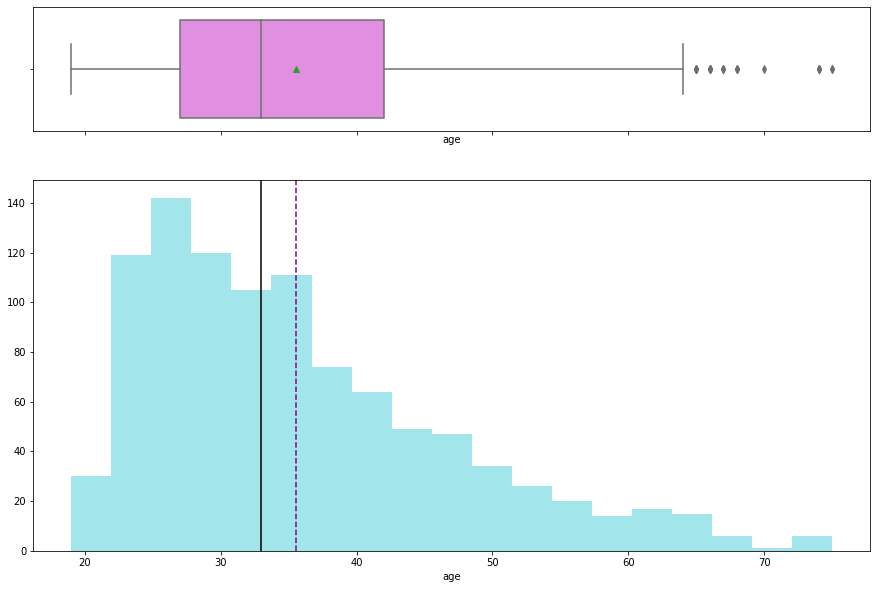

In [135]:
histogram_boxplot(data['age'])

* The distribution of the age is slightly skewed to the right.
* From the box plot we can see a few outliers


### Observations on Credit Amount

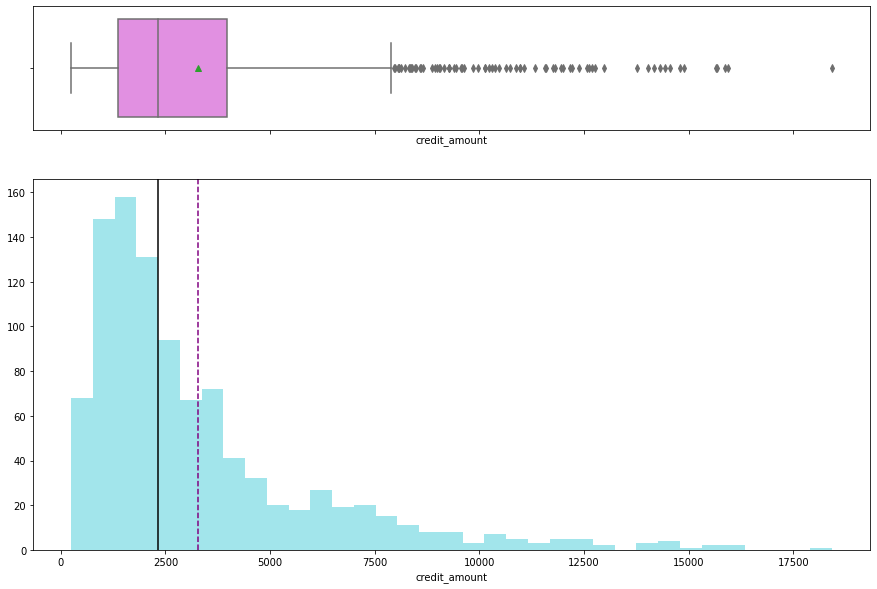

In [136]:
histogram_boxplot(data['credit_amount'])

* The distribution of the Credit_Limit is skewed to the right.
* There are quite very few customers with higher credit limits (above 150k).
* 50% of the customers of the bank have a credit limit of less than <2500

 ** Plotting the Categorical Data **

In [137]:
# Function to create barplots that indicate percentage for each category.

def perc_on_bar(z):
    '''
    plot
    feature: categorical feature
    the function won't work if a column is passed in hue parameter
    '''

    total = len(data[z]) # length of the column
    plt.figure(figsize=(15,5))
    ax = sns.countplot(data[z],palette='Paired')
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total) # percentage of each class of the category
        x = p.get_x() + p.get_width() / 2 - 0.05 # width of the plot
        y = p.get_y() + p.get_height()           # hieght of the plot
        
        ax.annotate(percentage, (x, y), size = 12) # annotate the percantage 
    plt.show() # show the plot

### Observations on credit_history

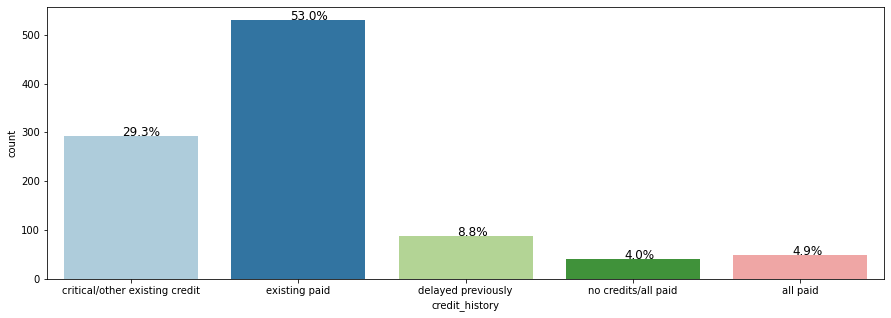

In [138]:
perc_on_bar('credit_history')

### Observations on purpose

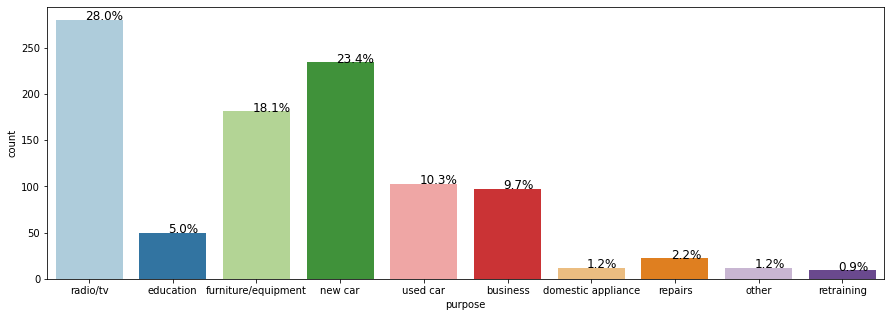

In [139]:
perc_on_bar('purpose')

### Observations on savings status

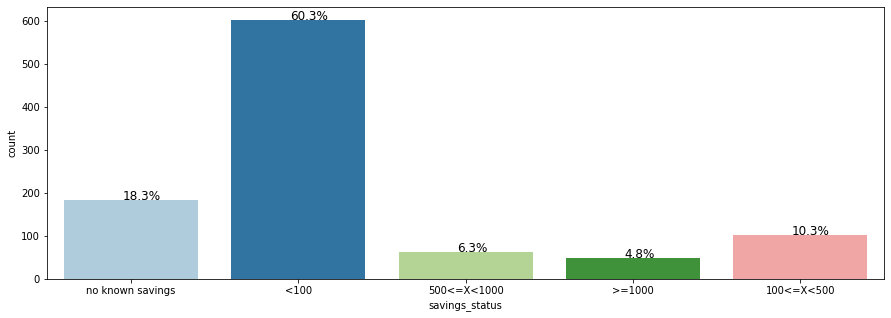

In [140]:
perc_on_bar('savings_status')

### Observations on property magnitude

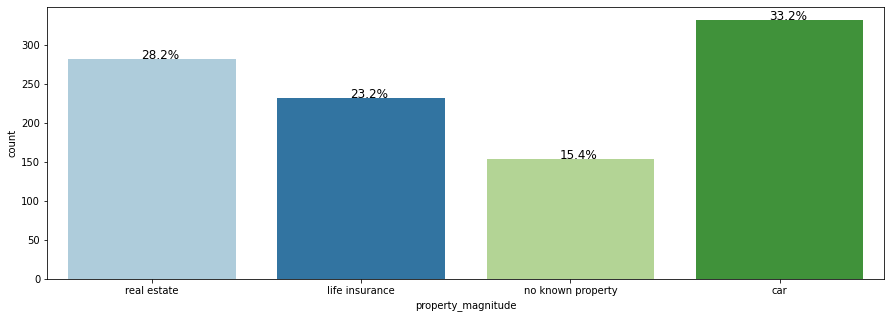

In [142]:
perc_on_bar('property_magnitude')

### Observations on number of dependents

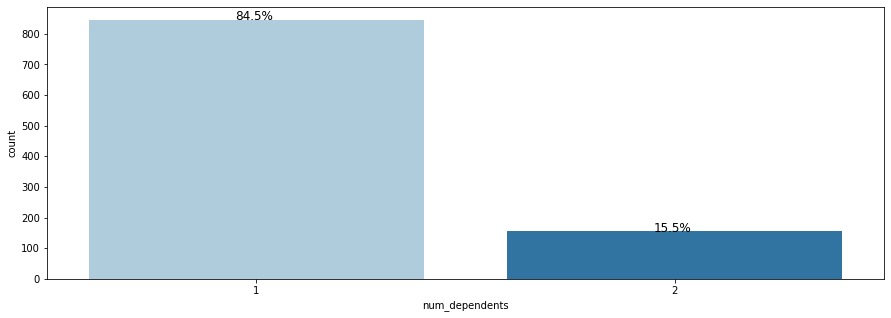

In [143]:
perc_on_bar('num_dependents')

### Observations on Class (Target Variable)

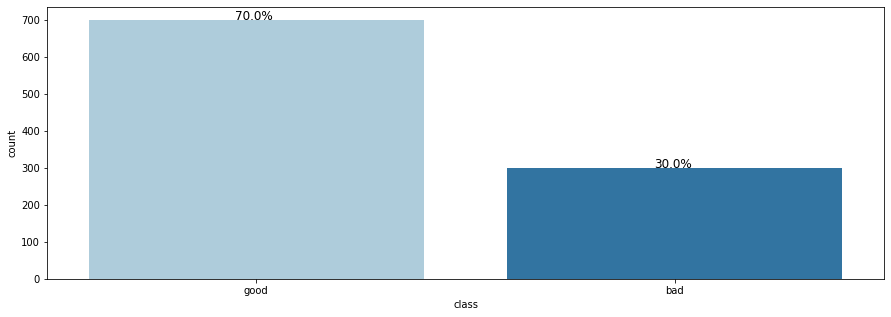

In [144]:
perc_on_bar('class')

## Bivariate Analysis

In [145]:
## Encoding the target variable class - bad and good customers to 0 and 1 respectively, for analysis.
data['class'].replace('bad',0,inplace=True)
data['class'].replace('good',1,inplace=True)

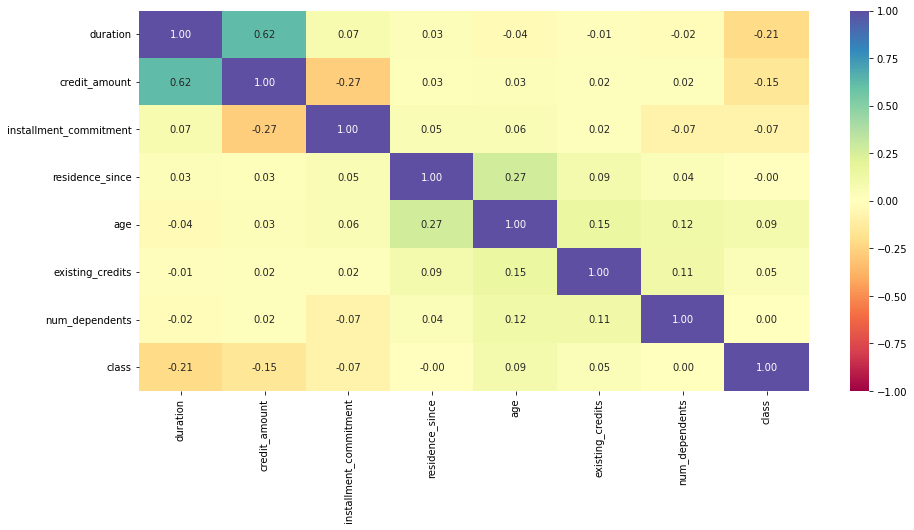

In [146]:
plt.figure(figsize=(15,7))
sns.heatmap(data.corr(),annot=True,vmin=-1,vmax=1,fmt='.2f',cmap='Spectral')
plt.show()


* There's a strong positive correlation between credit_amount and duration
* Negative correlation between class and duration & between installment_commitment and credit_amount



## Data Preparation

### Finding the percentage of outliers, in each column of the data, using IQR.

In [147]:
Q1 = data.quantile(0.25)             #To find the 25th percentile and 75th percentile.
Q3 = data.quantile(0.75)

IQR = Q3 - Q1                           #Inter Quantile Range (75th perentile - 25th percentile)

lower=Q1-1.5*IQR                        #Finding lower and upper bounds for all values. All values outside these bounds are outliers
upper=Q3+1.5*IQR

In [148]:
((data.select_dtypes(include=['float64','int64'])<lower) | (data.select_dtypes(include=['float64','int64'])>upper)).sum()/len(data)*100

duration                  7.000
credit_amount             7.200
installment_commitment    0.000
residence_since           0.000
age                       2.300
existing_credits          0.600
num_dependents           15.500
class                     0.000
dtype: float64

Lets convert the columns with an 'object' datatype into categorical variables

In [149]:
for feature in data.columns: # Loop through all columns in the dataframe
    if data[feature].dtype == 'object': # Only apply for columns with categorical strings
        data[feature] = pd.Categorical(data[feature])# Replace object with categorical
data.head(5)

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6,critical/other existing credit,radio/tv,1169,no known savings,>=7,4,male single,none,4,real estate,67,none,own,2,skilled,1,yes,yes,1
1,0<=X<200,48,existing paid,radio/tv,5951,<100,1<=X<4,2,female div/dep/mar,none,2,real estate,22,none,own,1,skilled,1,none,yes,0
2,no checking,12,critical/other existing credit,education,2096,<100,4<=X<7,2,male single,none,3,real estate,49,none,own,1,unskilled resident,2,none,yes,1
3,<0,42,existing paid,furniture/equipment,7882,<100,4<=X<7,2,male single,guarantor,4,life insurance,45,none,for free,1,skilled,2,none,yes,1
4,<0,24,delayed previously,new car,4870,<100,1<=X<4,3,male single,none,4,no known property,53,none,for free,2,skilled,2,none,yes,0


In [150]:
# Extracting the Gender information from personal_status and creating a new feature
data['Gender'] = data['personal_status'].str.split(' ').str[0]

In [151]:
data.Gender.value_counts()

male      690
female    310
Name: Gender, dtype: int64

In [152]:
# Removing the Gender information and making personal_status as a feature with new values
data['personal_status'] = data['personal_status'].str.split(' ').str[1]

In [153]:
data.personal_status.value_counts()

single         548
div/dep/mar    310
mar/wid         92
div/sep         50
Name: personal_status, dtype: int64

### Encoding the categorical features

In [154]:
# Creating a dictionary of replacement structure by assigning numerical encoding to values in ranges in checking_status, savings_Status, employment and class
replaceStruct = {
                "checking_status": {"no checking": 1, "<0": 2 ,"0<=X<200": 3 ,">=200": 4},
                "savings_status": {"<100": 1, "no known savings":2 , "100<=X<500": 3, "500<=X<1000": 4,">=1000": 5},
                 "employment": {"1<=X<4": 1, ">=7":2 , "4<=X<7": 3, "<1": 4,"unemployed": 5},
                 #"class":     {"bad": 0, "good": 1 } 
                    }

In [155]:
data = data.replace(replaceStruct)

In [156]:
data.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class,Gender
0,2,6,critical/other existing credit,radio/tv,1169,2,2,4,single,none,4,real estate,67,none,own,2,skilled,1,yes,yes,1,male
1,3,48,existing paid,radio/tv,5951,1,1,2,div/dep/mar,none,2,real estate,22,none,own,1,skilled,1,none,yes,0,female
2,1,12,critical/other existing credit,education,2096,1,3,2,single,none,3,real estate,49,none,own,1,unskilled resident,2,none,yes,1,male
3,2,42,existing paid,furniture/equipment,7882,1,3,2,single,guarantor,4,life insurance,45,none,for free,1,skilled,2,none,yes,1,male
4,2,24,delayed previously,new car,4870,1,1,3,single,none,4,no known property,53,none,for free,2,skilled,2,none,yes,0,male


In [157]:
# Creating a list of features for one hot encoding
oneHotCols=["credit_history","purpose","personal_status","other_parties", "property_magnitude","other_payment_plans", "housing", "job", "own_telephone", "foreign_worker", "Gender"]

In [158]:
# Removing the spaces from the start and end in column names
data.columns = data.columns.str.strip()

In [159]:
data =  pd.get_dummies(data, columns=oneHotCols)
data.head()

,checking_status,duration,credit_amount,savings_status,employment,installment_commitment,residence_since,age,existing_credits,num_dependents,class,credit_history_all paid,credit_history_critical/other existing credit,credit_history_delayed previously,credit_history_existing paid,credit_history_no credits/all paid,purpose_business,purpose_domestic appliance,purpose_education,purpose_furniture/equipment,purpose_new car,purpose_other,purpose_radio/tv,purpose_repairs,purpose_retraining,purpose_used car,personal_status_div/dep/mar,personal_status_div/sep,personal_status_mar/wid,personal_status_single,other_parties_co applicant,other_parties_guarantor,other_parties_none,property_magnitude_car,property_magnitude_life insurance,property_magnitude_no known property,property_magnitude_real estate,other_payment_plans_bank,other_payment_plans_none,other_payment_plans_stores,housing_for free,housing_own,housing_rent,job_high qualif/self emp/mgmt,job_skilled,job_unemp/unskilled non res,job_unskilled resident,own_telephone_none,own_telephone_yes,foreign_worker_no,foreign_worker_yes,Gender_female,Gender_male
0,2,6,1169,2,2,4,4,67,2,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,1
1,3,48,5951,1,1,2,2,22,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,1,0
2,1,12,2096,1,3,2,3,49,1,2,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,1
3,2,42,7882,1,3,2,4,45,1,2,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,1
4,2,24,4870,1,1,3,4,53,2,2,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,1


## Split the data into train and test sets

In [160]:
X = data.drop("class" , axis=1)
y = data.pop("class")

In [161]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=1,stratify=y)

#Stratify = Y  is an option that allows to create training and test sets that are consistent. 
# With target variable. 
#“Y” in stratify refers to the target variable. Critical for Imbalanced Data sets!!

## <a id = "link6"></a> Model Building

## Model evaluation criterion

### Model can make wrong predictions as:
1. Predicting a customer as risk and the customer is not a risk
2. Predicting a customer is not a risk and the customer is risk

### Which case is more important? 
* Predicting that customer is not a risk but the customer is a risk i.e. losing business as the customer can default. 

### How to minimise the risk i.e need to reduce False Negatives?
* Weka German Credit want `Recall` to be maximized, greater the Recall higher the chances of minimizing false negatives. Hence, the focus should be on increasing Recall or minimizing the false negatives or in other words identifying the true positives(i.e. Class 1) so that the bank can protect the business by identifying the customers who are at risk.

**Before modelling, let's create two functions to calculate different metrics and confusion matrix, so that we don't have to use the same code repeatedly for each model.**

In [162]:
def make_confusion_matrix(model,y_actual,labels=[1, 0]):
    '''
    model : classifier to predict values of X
    y_actual : ground truth  
    
    '''
    y_predict = model.predict(X_test)
    cm=metrics.confusion_matrix( y_actual, y_predict, labels=[0, 1])
    df_cm = pd.DataFrame(cm, index = [i for i in ["Actual - No","Actual - Yes"]],
                  columns = [i for i in ['Predicted - No','Predicted - Yes']])
    group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=labels,fmt='')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [163]:
def get_metrics_score(model,train,test,train_y,test_y,flag=True):
    '''
    model : classifier to predict values of X

    '''
    # defining an empty list to store train and test results
    score_list=[] 
    
    pred_train = model.predict(train)
    pred_test = model.predict(test)
    
    train_acc = model.score(train,train_y)
    test_acc = model.score(test,test_y)
    
    train_recall = metrics.recall_score(train_y,pred_train)
    test_recall = metrics.recall_score(test_y,pred_test)
    
    train_precision = metrics.precision_score(train_y,pred_train)
    test_precision = metrics.precision_score(test_y,pred_test)
    
    score_list.extend((train_acc,test_acc,train_recall,test_recall,train_precision,test_precision))
        
    # If the flag is set to True then only the following print statements will be dispayed. The default value is set to True.
    if flag == True: 
        print("Accuracy on training set : ",model.score(train,train_y))
        print("Accuracy on test set : ",model.score(test,test_y))
        print("Recall on training set : ",metrics.recall_score(train_y,pred_train))
        print("Recall on test set : ",metrics.recall_score(test_y,pred_test))
        print("Precision on training set : ",metrics.precision_score(train_y,pred_train))
        print("Precision on test set : ",metrics.precision_score(test_y,pred_test))
    
    return score_list # returning the list with train and test scores

### <a id = "link6"></a> Logistic Regression

In [164]:
lr = LogisticRegression(random_state=1)
lr.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

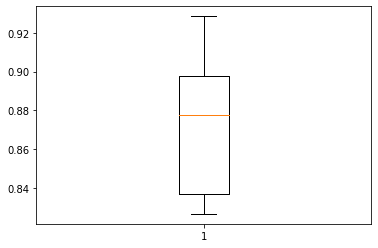

In [165]:
scoring='recall'
kfold=StratifiedKFold(n_splits=5,shuffle=True,random_state=1)     #Setting number of splits equal to 5
cv_result_bfr=cross_val_score(estimator=lr, X=X_train, y=y_train, scoring=scoring, cv=kfold)
#Plotting boxplots for CV scores of model defined above
plt.boxplot(cv_result_bfr)
plt.show()

Accuracy on training set :  0.73
Accuracy on test set :  0.7166666666666667
Recall on training set :  0.8857142857142857
Recall on test set :  0.9047619047619048
Precision on training set :  0.7654320987654321
Precision on test set :  0.7450980392156863


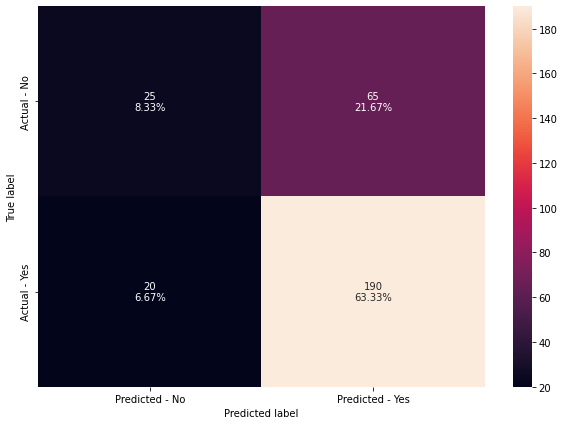

In [166]:
#Calculating different metrics
scores_LR = get_metrics_score(lr,X_train,X_test,y_train,y_test)

# creating confusion matrix
make_confusion_matrix(lr,y_test)

### Random Forest

In [167]:
%%time

# Creating pipeline
pipe = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=1))

# Parameter grid to pass in RandomSearchCV
param_grid = {
    "randomforestclassifier__n_estimators": [100,150,250],
    "randomforestclassifier__min_samples_leaf": np.arange(1, 6),
    "randomforestclassifier__max_features": [np.arange(0.3, 0.6, 0.1),'sqrt','log2'],
    "randomforestclassifier__max_samples": np.arange(0.2, 0.6, 0.1),
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=pipe, param_distributions=param_grid, n_jobs = -1, n_iter=50, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'randomforestclassifier__n_estimators': 150, 'randomforestclassifier__min_samples_leaf': 3, 'randomforestclassifier__max_samples': 0.2, 'randomforestclassifier__max_features': 'log2'} with CV score=0.9918367346938777:
CPU times: user 2.13 s, sys: 85.6 ms, total: 2.21 s
Wall time: 22.9 s


In [168]:
# Creating new pipeline with best parameters
rf_tuned2 = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(
        n_estimators=150,
        max_features='log2',
        random_state=1,
        max_samples=0.2,
        min_samples_leaf=3
    ),
)

# Fit the model on training data
rf_tuned2.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='log2',
                                        max_leaf_nodes=None, max_samples=0.2,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=3, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=150, n_jobs=None,
                                        oob_score=False, random_state=1,
                                        verbose=0, warm_start=False))],
         verbose=False

Accuracy on training set :  0.7514285714285714
Accuracy on test set :  0.7066666666666667
Recall on training set :  0.9938775510204082
Recall on test set :  0.9904761904761905
Precision on training set :  0.7401215805471124
Precision on test set :  0.7074829931972789


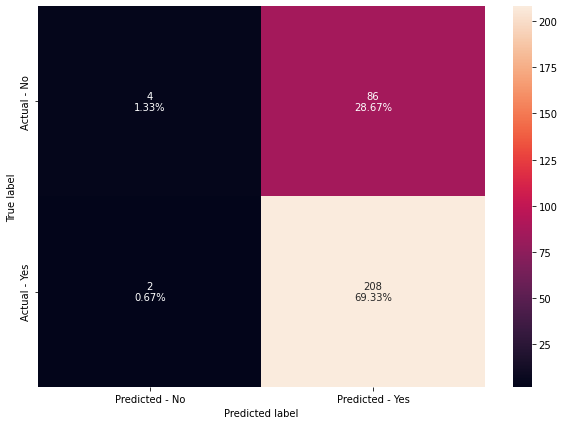

In [169]:
# Calculating different metrics
get_metrics_score(rf_tuned2,X_train,X_test,y_train,y_test)

# Creating confusion matrix
make_confusion_matrix(rf_tuned2, y_test)

### XGBoost

In [170]:
%%time 

#Creating pipeline
pipe=make_pipeline(StandardScaler(),XGBClassifier(random_state=1,eval_metric='logloss'))

#Parameter grid to pass in RandomSearchCV
param_grid={'xgbclassifier__n_estimators':np.arange(50,300,50),'xgbclassifier__scale_pos_weight':[0,1,2,5,10],
            'xgbclassifier__learning_rate':[0.01,0.1,0.2,0.05], 'xgbclassifier__gamma':[0,1,3,5],
            'xgbclassifier__subsample':[0.7,0.8,0.9,1]}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=pipe, param_distributions=param_grid, n_iter=50, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'xgbclassifier__subsample': 1, 'xgbclassifier__scale_pos_weight': 10, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__learning_rate': 0.05, 'xgbclassifier__gamma': 5} with CV score=1.0:
CPU times: user 1.83 s, sys: 43.8 ms, total: 1.87 s
Wall time: 15.3 s


In [171]:
# Creating new pipeline with best parameters
xgb_tuned2 = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        (
            "XGB",
            XGBClassifier(
                random_state=1,
                n_estimators=50,
                scale_pos_weight=10,
                learning_rate=0.05,
                gamma=5,
                subsample=1,
                eval_metric='logloss',
            ),
        ),
    ]
)
# Fit the model on training data
xgb_tuned2.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('XGB',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, eval_metric='logloss',
                               gamma=5, learning_rate=0.05, max_delta_step=0,
                               max_depth=3, min_child_weight=1, missing=None,
                               n_estimators=50, n_jobs=1, nthread=None,
                               objective='binary:logistic', random_state=1,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=10,
                               seed=None, silent=None, subsample=1,
                               verbosity=1))],
         verbose=False)

Accuracy on training set :  0.7128571428571429
Accuracy on test set :  0.6966666666666667
Recall on training set :  1.0
Recall on test set :  0.9904761904761905
Precision on training set :  0.7091172214182344
Precision on test set :  0.7003367003367004


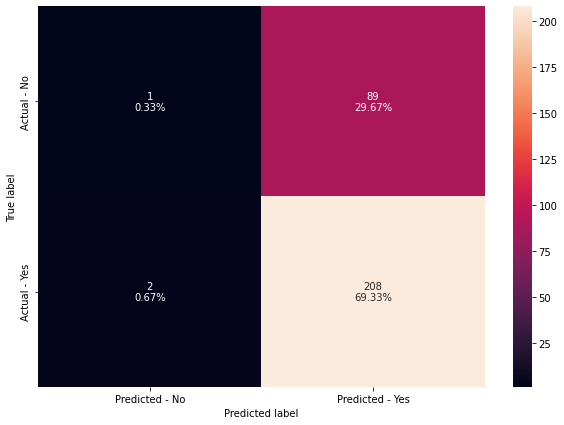

In [172]:
# Calculating different metrics
get_metrics_score(xgb_tuned2,X_train,X_test,y_train,y_test)

# Creating confusion matrix
make_confusion_matrix(xgb_tuned2, y_test)

### Comparing All Models

In [173]:
# defining list of models
models = [xgb_tuned2, lr , rf_tuned2]

# defining empty lists to add train and test results
acc_train = []
acc_test = []
recall_train = []
recall_test = []
precision_train = []
precision_test = []

# looping through all the models to get the metrics score - Accuracy, Recall and Precision
for model in models:

    j = get_metrics_score(model,X_train,X_test,y_train,y_test,False)
    acc_train.append(j[0])
    acc_test.append(j[1])
    recall_train.append(j[2])
    recall_test.append(j[3])
    precision_train.append(j[4])
    precision_test.append(j[5])

In [178]:
comparison_frame = pd.DataFrame(
    {
        "Model": [
            "XGBoost",
            'Logistic Regression',
            'Random Forest',
          
        ],
        "Train_Accuracy": acc_train,
        "Test_Accuracy": acc_test,
        "Train_Recall": recall_train,
        "Test_Recall": recall_test,
        "Train_Precision": precision_train,
        "Test_Precision": precision_test,
    }
)

comparison_frame

,Model,Train_Accuracy,Test_Accuracy,Train_Recall,Test_Recall,Train_Precision,Test_Precision
0,XGBoost,0.713,0.697,1.000,0.990,0.709,0.700
1,Logistic Regression,0.730,0.717,0.886,0.905,0.765,0.745
2,Random Forest,0.751,0.707,0.994,0.990,0.740,0.707


- The Random Forest tuned with RandomizedSearchCV is giving the best test_recall along with XGBoost and overall generalised performance
- The XGBoost is slightly more generalised as not much difference in train and test accuracy scores.



### Feature Importance for XGBoost

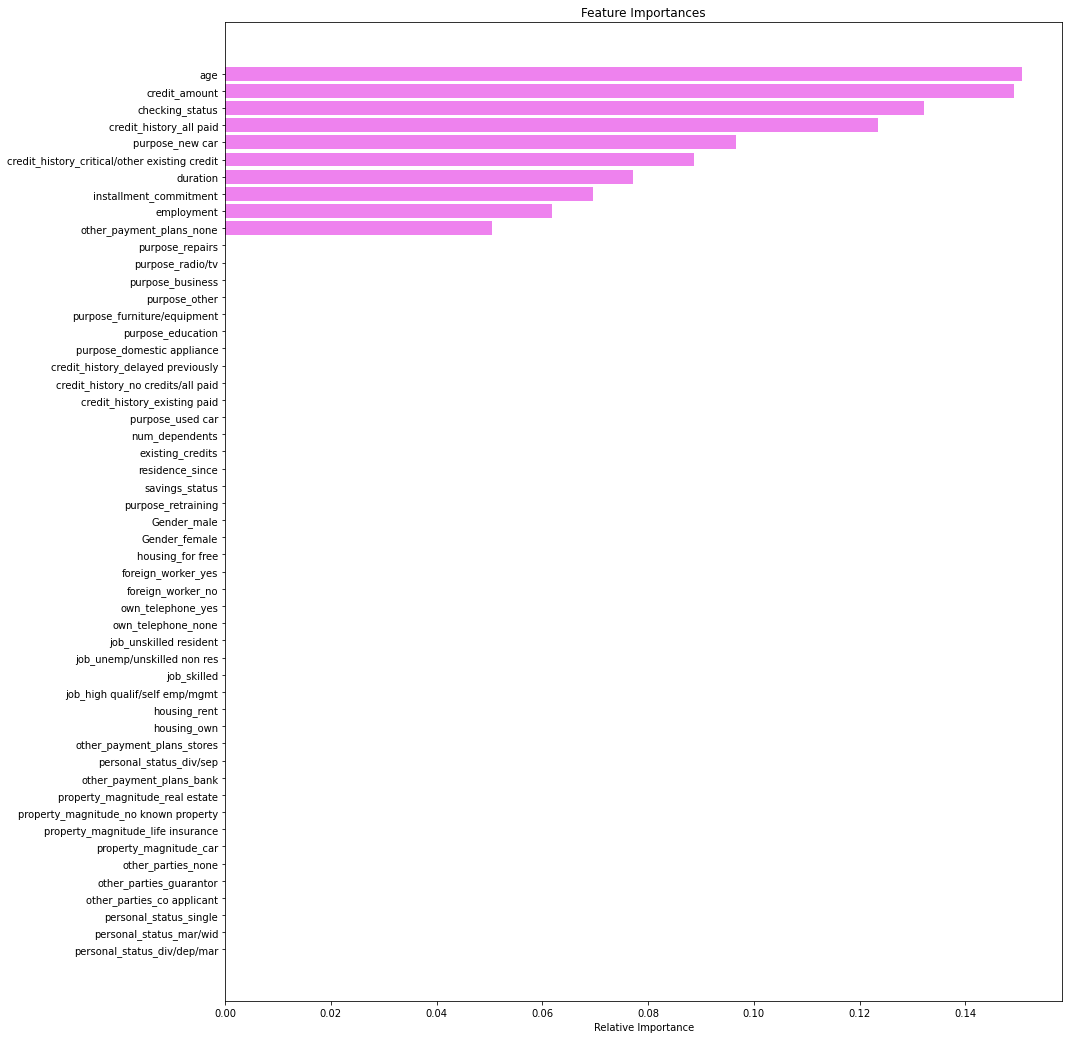

In [175]:
feature_names = X_train.columns
importances = xgb_tuned2[1].feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(15, 18))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

### Feature Importance for Random Forest

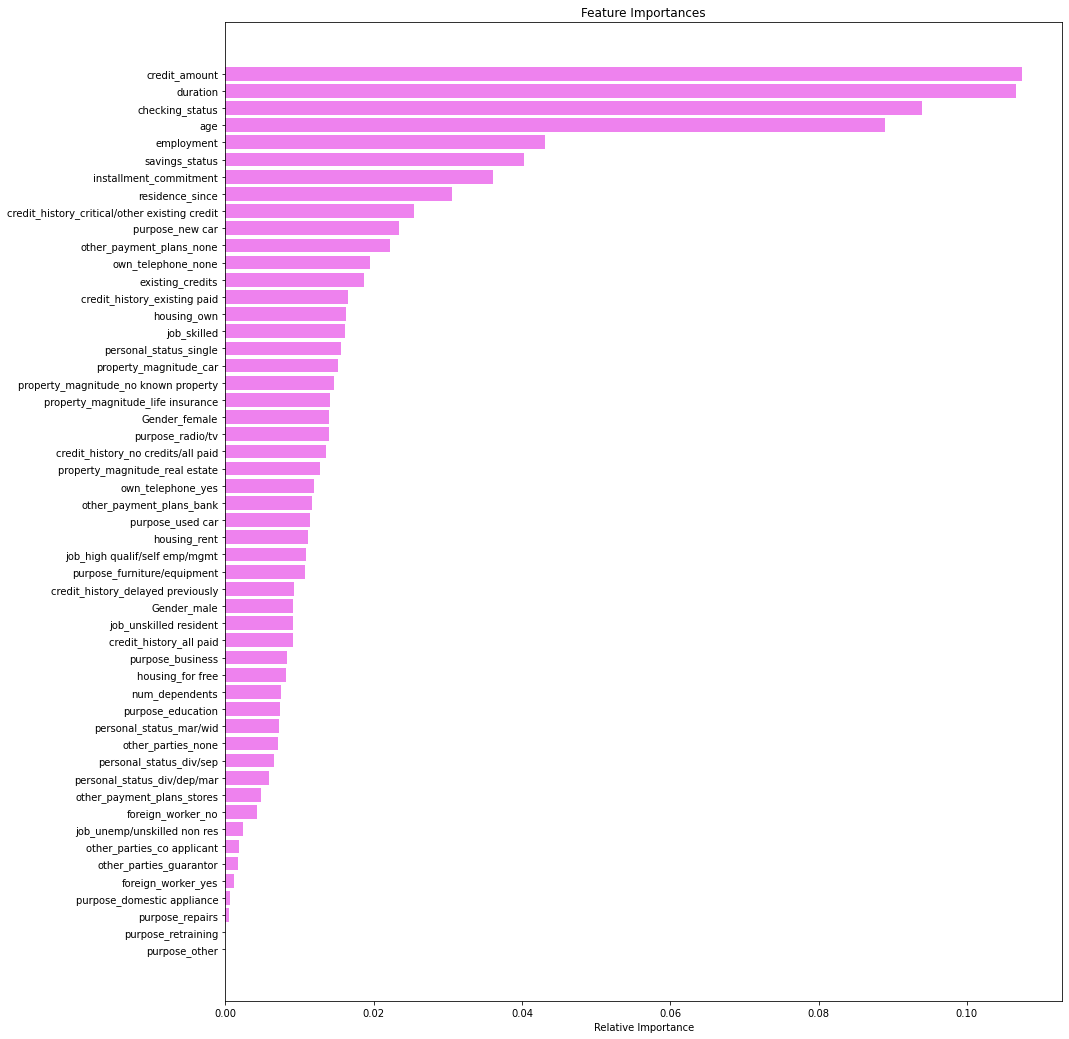

In [177]:
feature_names = X_train.columns
importances = rf_tuned2[1].feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(15, 18))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

